In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
os.listdir('../data/stocknews/')

['RedditNews.csv', 'Combined_News_DJIA.csv', 'upload_DJIA_table.csv']

In [3]:
df_reddit = pd.read_csv('../data/stocknews/RedditNews.csv')
df_news = pd.read_csv('../data/stocknews/Combined_News_DJIA.csv')
df_djia = pd.read_csv('../data/stocknews/upload_DJIA_table.csv')


In [4]:
df_djia_news = pd.merge(df_djia, df_news, on='Date', how='inner')

df = pd.merge(df_djia_news, df_reddit, on='Date', how='inner')

In [5]:
df_djia_news['Top1'][0]

'A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898.'

# Sentiment Analysis

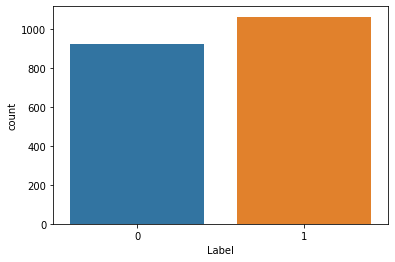

In [6]:
# 0 = decrease , 1 = increase or equal at Adj.Close
sns.countplot(x='Label', data=df_news)

In [7]:
# Preprocess 
def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('',text)

In [8]:
df_news['Top1'][0]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"'

In [9]:
X = list()
sentences = df_news['Top1']
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = df_news['Label']

In [67]:
X

['b Georgia downs two Russian warplanes as countries move to brink of war ',
 'b Why wont America and Nato help us If they wont help us now why did we help them in Iraq ',
 'b Remember that adorable year old who sang at the opening ceremonies That was fake too ',
 'b S refuses Israel weapons to attack Iran report ',
 'b All the experts admit that we should legalise drugs ',
 'b Mom of missing gay man Too bad he not year old cheerleader then they still be looking for him ',
 'b In an Afghan prison the majority of female prisoners are serving year sentences for being victims of rape ',
 'b Man arrested and locked up for five hours after taking photo of police van ignoring no entry sign ',
 'b Two elderly Chinese women have been sentenced to year of re education through labor after they sought permit to demonstrate in an official Olympic protest area ',
 'b British resident held in Guantanamo Bay wins legal battle to force Foreign Office to reveal torture evidence ',
 'b Syria says its re

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [12]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

6659

In [14]:
# !touch glove.txt

Simple NN

In [35]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          1997700   
_________________________________________________________________
flatten_4 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               15000500  
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 501       
Total params: 16,998,701
Trainable params: 15,001,001
Non-trainable params: 1,997,700
_________________________________________________________________
None


In [36]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Train on 1272 samples, validate on 319 samples
Epoch 1/10
1272/1272 [==============================] - 2s 1ms/sample - loss: 1.1025 - acc: 0.4827 - val_loss: 0.6923 - val_acc: 0.5611
Epoch 2/10
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.6931 - acc: 0.5432 - val_loss: 0.6918 - val_acc: 0.5361
Epoch 3/10
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.6942 - acc: 0.5047 - val_loss: 0.6921 - val_acc: 0.5361
Epoch 4/10
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.6882 - acc: 0.5495 - val_loss: 0.6896 - val_acc: 0.5361
Epoch 5/10
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.6842 - acc: 0.5480 - val_loss: 0.6914 - val_acc: 0.5361
Epoch 6/10
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.6823 - acc: 0.5621 - val_loss: 0.6899 - val_acc: 0.5361
Epoch 7/10
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.6785 - acc: 0.5645 - val_loss: 0.6905 - val_acc: 0.5361
E

398/398 [==============================] - 0s 798us/sample - loss: 0.6955 - acc: 0.4950
Test Score: 0.6955134934516408
Test Accuracy: 0.49497488


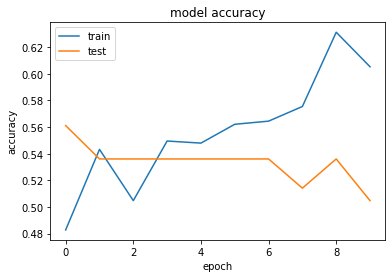

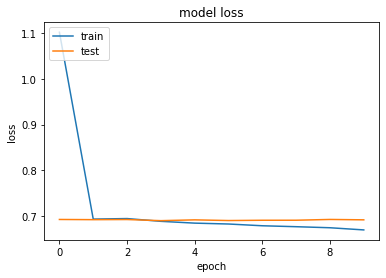

In [37]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Conv1D 

In [40]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 300, input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 300)          1997700   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 2,202,829
Trainable params: 205,129
Non-trainable params: 1,997,700
______________________________________

Train on 1272 samples, validate on 319 samples
Epoch 1/10
1272/1272 [==============================] - 2s 2ms/sample - loss: 0.6910 - acc: 0.5212 - val_loss: 0.6922 - val_acc: 0.5361
Epoch 2/10
1272/1272 [==============================] - 1s 977us/sample - loss: 0.6865 - acc: 0.5417 - val_loss: 0.6905 - val_acc: 0.5361
Epoch 3/10
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.6797 - acc: 0.5715 - val_loss: 0.6896 - val_acc: 0.5361
Epoch 4/10
1272/1272 [==============================] - 1s 961us/sample - loss: 0.6684 - acc: 0.6329 - val_loss: 0.6889 - val_acc: 0.5361
Epoch 5/10
1272/1272 [==============================] - 1s 952us/sample - loss: 0.6494 - acc: 0.6077 - val_loss: 0.6880 - val_acc: 0.5235
Epoch 6/10
1272/1272 [==============================] - 1s 973us/sample - loss: 0.6214 - acc: 0.7453 - val_loss: 0.6871 - val_acc: 0.5298
Epoch 7/10
1272/1272 [==============================] - 1s 978us/sample - loss: 0.5726 - acc: 0.8923 - val_loss: 0.6866 - val_acc

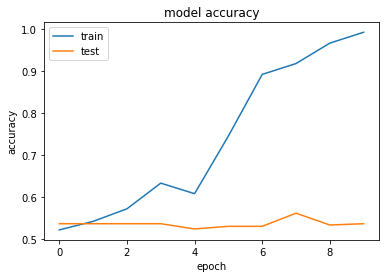

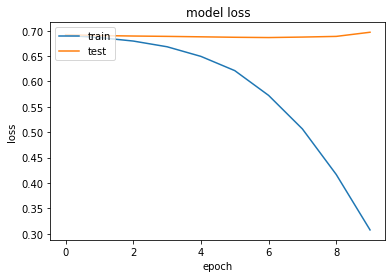

In [41]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

LSTM 

In [59]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=1e-3, decay=1e-2), loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 300)          1997700   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_28 (Dense)             (None, 100)               12900     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 101       
Total params: 2,230,749
Trainable params: 232,849
Non-trainable params: 1,997,900
_________________________________________________________________
None


Train on 1272 samples, validate on 319 samples
Epoch 1/10
1272/1272 [==============================] - 7s 5ms/sample - loss: 0.7088 - acc: 0.4890 - val_loss: 0.6907 - val_acc: 0.5361
Epoch 2/10
1272/1272 [==============================] - 5s 4ms/sample - loss: 0.6989 - acc: 0.5047 - val_loss: 0.6905 - val_acc: 0.5361
Epoch 3/10
1272/1272 [==============================] - 5s 4ms/sample - loss: 0.6992 - acc: 0.5189 - val_loss: 0.6908 - val_acc: 0.5361
Epoch 4/10
1272/1272 [==============================] - 5s 4ms/sample - loss: 0.6892 - acc: 0.5566 - val_loss: 0.6910 - val_acc: 0.5361
Epoch 5/10
1272/1272 [==============================] - 5s 4ms/sample - loss: 0.7005 - acc: 0.5024 - val_loss: 0.6909 - val_acc: 0.5361
Epoch 6/10
1272/1272 [==============================] - 5s 4ms/sample - loss: 0.6891 - acc: 0.5393 - val_loss: 0.6910 - val_acc: 0.5361
Epoch 7/10
1272/1272 [==============================] - 5s 4ms/sample - loss: 0.6968 - acc: 0.5346 - val_loss: 0.6907 - val_acc: 0.5361
E

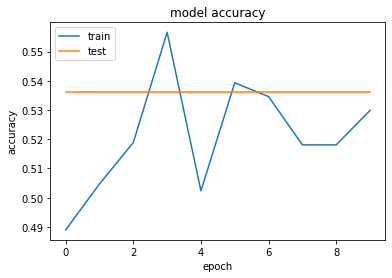

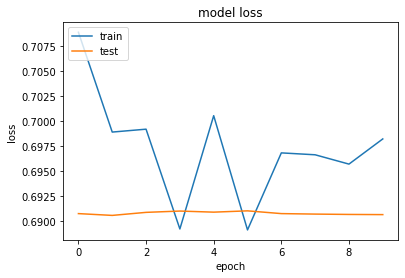

In [60]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Prediction

In [ ]:
instance = X[57]
instance = tokenizer.texts_to_sequences(instance)

flat_list = list()
for sublist in instance:
    for item in sublist:
        flat_list.append(item)
        
flat_list = [flat_list]
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

In [64]:
X[547]

' The trapped Chilean miners have moved to stop any individual from profiting at the expense of the group drawing up legal contract to share the proceeds from the story of their ordeal '

array([   6,  121, 1087, 1969,  622,   64, 3045,  121,  208,  882,  623,
        883,  122,    5,  723,    9,  884,    1,  724,  209,  376, 1397,
         69, 1970,   11,  134,  208,  476,   62,  623,  477, 1971, 1972,
       1398,   39, 1973,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)